In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
def transform_str_chromosome(pandas_series):
    return pandas_series.apply(lambda x: int(x[3:]))

## Load data

### CpG Islands

In [3]:
cpg_islands = pd.read_csv('data/cpgIslandExt.txt', sep = '\t', header = None).iloc[:,1:4]
cpg_islands = cpg_islands.rename(columns = {1:'chromosome',2:'start',3:'stop'})
chromosomes = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14',
               'chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
cpg_islands = cpg_islands[cpg_islands['chromosome'].isin(chromosomes)]
cpg_islands['chromosome'] = transform_str_chromosome(cpg_islands['chromosome'])
cpg_islands = cpg_islands.sort_values(['chromosome', 'start'])
cpg_islands.head(5)

,chromosome,start,stop
0,1,28735,29810
1,1,135124,135563
2,1,327790,328229
3,1,437151,438164
4,1,449273,450544


### Chromosomes length

In [4]:
chrom_len = pd.read_csv('data/hg19.chrom.sizes.txt', sep = '\t', header = None, names = ['chromosome','length'])
chromosomes = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14',
               'chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
chrom_len = chrom_len[chrom_len['chromosome'].isin(chromosomes)]
chrom_len['chromosome'] = transform_str_chromosome(chrom_len['chromosome'])

chrom_len.head()

,chromosome,length
0,1,249250621
1,2,243199373
2,3,198022430
3,4,191154276
4,5,180915260


In [5]:
data = cpg_islands.merge(chrom_len)
data.head()

,chromosome,start,stop,length
0,1,28735,29810,249250621
1,1,135124,135563,249250621
2,1,327790,328229,249250621
3,1,437151,438164,249250621
4,1,449273,450544,249250621


### DNA Methylation

In [6]:
chromosomes = ['chr1','chr2','chr3','chr4','chr5','chr6','chr7','chr8','chr9','chr10','chr11','chr12','chr13','chr14',
               'chr15','chr16','chr17','chr18','chr19','chr20','chr21','chr22']
dna_methylation = []
with open("data/HAIB.A549.EtOH.Rep.3.bed")as f:
    for line in f:
        row = line.strip().split()
        if row[0] in chromosomes:
            chromosome = int(row[0][3:])
            start = int(row[1])
            stop = int(row[2])
            dna_methylation.append((chromosome, start, stop))

## Create CPG Islands, Shores, Shelves, Seas

In [7]:
def create_bed(data, window):
    """
    data must be sorted by chromosome, start
    """    
    # Final Value lists
    cpg_islands = []
    shores = []
    shelves = []
    seas = []
    
    prev_start = data.iloc[0]['start']
    prev_stop = data.iloc[0]['stop']
    prev_chromosome = data.iloc[0]['chromosome']
    prev_chromosome_len = data.iloc[0]['length']
    
    
    
    # First CPG Island - left
    cpg_islands.append((prev_chromosome, prev_start, prev_stop))
    if prev_start > (2*window):
        seas.append((prev_chromosome, 0, prev_start - 2*window))
        shelves.append((prev_chromosome, prev_start - 2*window, prev_start - window))
        shores.append((prev_chromosome, prev_start - window, prev_start))
    elif prev_start > (window):
        shelves.append((prev_chromosome, 0, prev_start - window))
        shores.append((prev_chromosome, prev_start - window, prev_start))  
    elif prev_start < (window):
        shores.append((prev_chromosome, 0, prev_start))
    else:
        print("Something's wrong")
    
    
    
    # CPG Islands from 1 to n-1
    for i in tqdm(range(1, data.shape[0]), desc = 'CPG Islands'):
        start = data.iloc[i]['start']
        stop = data.iloc[i]['stop']
        chromosome = data.iloc[i]['chromosome']        
        chromosome_len = data.iloc[i]['length']
        
        # LEFT SIDE OF CPG ISLAND
        if prev_chromosome == chromosome:
            if start - prev_stop > (4*window):
                shores.append((chromosome, prev_stop, prev_stop + window))
                shelves.append((chromosome, prev_stop + window, prev_stop + 2*window))
                seas.append((chromosome, prev_stop + 2*window, start - 2*window))
                shelves.append((chromosome, start - 2*window, start - window))
                shores.append((chromosome, start - window, start))
            elif start - prev_stop > (2*window):
                shores.append((chromosome, prev_stop, prev_stop + window))
                shelves.append((chromosome, prev_stop + window, start - window))
                shores.append((chromosome, start - window, start))                
            elif start - prev_stop > (window):
                shores.append((chromosome, prev_stop, start))
            elif start - prev_stop <= (window):
                shores.append((chromosome, prev_stop, start))
            else:
                print("Something's wrong")
                
        elif prev_chromosome != chromosome:
            # PREV side
            if prev_chromosome_len - prev_stop > (2*window):
                shores.append((prev_chromosome, prev_stop, prev_stop + window))
                shelves.append((prev_chromosome, prev_stop + window, prev_stop + 2*window))
                seas.append((prev_chromosome, prev_stop + 2*window, prev_chromosome_len))
            elif prev_chromosome_len - prev_stop > (window):
                shores.append((prev_chromosome, prev_stop, prev_stop + window))
                shelves.append((prev_chromosome, prev_stop + window, prev_chromosome_len))
            elif prev_chromosome_len - prev_stop <= (window):
                shores.append((prev_chromosome, prev_stop, prev_chromosome_len))
            else:
                print("Something's wrong")
                
            # CURRENT side
            if start > (2*window):
                seas.append((chromosome, 0, start - 2*window))
                shelves.append((chromosome, start - 2*window, start - window))
                shores.append((chromosome, start - window, start))
            elif start > (window):
                shelves.append((chromosome, 0, start - window))
                shores.append((chromosome, start - window, start))   
            elif start <= (window):
                shores.append((chromosome, 0, start))
            else:
                print("Something's wrong")
        prev_start = start
        prev_stop = stop
        prev_chromosome = chromosome
        prev_chromosome_len = chromosome_len
        cpg_islands.append((chromosome, start, stop))
    
    # Last CPG Island - Right
    if prev_chromosome_len - prev_stop > (2*window):
        shores.append((prev_chromosome, prev_stop, prev_stop + window))
        shelves.append((prev_chromosome, prev_stop + window, prev_stop + 2*window))
        seas.append((prev_chromosome, prev_stop + 2*window, prev_chromosome_len))
    elif prev_chromosome_len - prev_stop > (window):
        shores.append((prev_chromosome, prev_stop, prev_stop + window))
        shelves.append((prev_chromosome, prev_stop + window, prev_chromosome_len))
    elif prev_chromosome_len - prev_stop <= (window):
        shores.append((prev_chromosome, prev_stop, prev_chromosome_len))
    else:
        print("Something's wrong")
    
    return cpg_islands, shelves, shores, seas

In [8]:
cpg_islands, shelves, shores, seas = create_bed(data, 2000)

CPG Islands: 100%|█████████████████████████████████████████████████████████████| 26640/26640 [00:10<00:00, 2458.38it/s]


In [9]:
def save_bed_format(filename, data):
    with open(filename+'.bed', 'w') as f:
        for row in data:
            f.write("%s\t%s\t%s\n" % row)

In [10]:
save_bed_format('cpg_islands', cpg_islands)
save_bed_format('shelves', shelves)
save_bed_format('shores', shores)
save_bed_format('seas', seas)

In [11]:
def calculate_hits(cpg_islands, shores, shelves, seas, dna_methylation):
    """
    All data must be in tuples
    (chromosome, start, stop)
    
    """
    # Prepare data
    cpg_islands_df = pd.DataFrame(cpg_islands, columns = ['chromosome','start','stop'])
    cpg_islands_df['region'] = 'cpg_island'
    shores_df = pd.DataFrame(shores, columns = ['chromosome','start','stop'])
    shores_df['region'] = 'shore'
    shelves_df = pd.DataFrame(shelves, columns = ['chromosome','start','stop'])
    shelves_df['region'] = 'shelve'
    seas_df = pd.DataFrame(seas, columns = ['chromosome','start','stop'])
    seas_df['region'] = 'sea'
    all_data = cpg_islands_df.append(shores_df, ignore_index=True).append(shelves_df, ignore_index=True).append(seas_df, ignore_index=True)
    all_data = all_data.sort_values(['chromosome','start'])
    
    regions = []
    for row in tqdm(dna_methylation, desc='DNA Methylation'):
        middle = row[1] + (row[2] - row[1])/2
        all_data_rows = all_data[(all_data['chromosome'] == row[0]) & (all_data['start'] <= middle) & (all_data['stop'] >= middle)]
        
        if all_data_rows.shape[0] > 1:
            all_data_rows = all_data_rows.iloc[[-1]]
        if all_data_rows.shape[0] == 0:
            print('no match')
            print(row)
        
        regions.append(all_data_rows['region'].values)
    return regions

In [12]:
regions = calculate_hits(cpg_islands, shores, shelves, seas, dna_methylation)

DNA Methylation: 100%|████████████████████████████████████████████████████████| 470870/470870 [12:24<00:00, 632.75it/s]


In [19]:
hits = pd.Series(regions).value_counts(normalize=True)
hits

[sea]           0.361896
[cpg_island]    0.280532
[shore]         0.261034
[shelve]        0.096538
dtype: float64

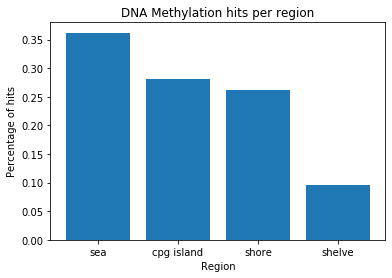

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.bar(['sea','cpg island','shore','shelve'],hits)
plt.title('DNA Methylation hits per region')
plt.ylabel('Percentage of hits')
plt.xlabel('Region')
plt.show()

In [37]:
np.sum(pd.Series(regions).value_counts())

470870